In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Подготовка

Проверяем доступность графического ускорителя. 

In [2]:
import torch
import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Выводим информацию о драйвере. Импортируем необходимые библиотеки.

In [3]:
!nvidia-smi

Fri Jan 08 23:13:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 445.87       Driver Version: 445.87       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:08:00.0  On |                  N/A |
|  0%   53C    P0    53W / 215W |   2320MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.cuda.get_device_name()

'GeForce RTX 2070 SUPER'

In [6]:
#DEVICE = torch.device('cpu')


Описываем класс SimpsonsDataset

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
TRAIN_DIR = Path('E:\\datasets\\train\\simpsons_dataset')
#../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('E:\\datasets\\testset\\testset\\') 
#../input/journey-springfield/testset/testset')


train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Разделяем данные на валидационные и тренеровочные

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

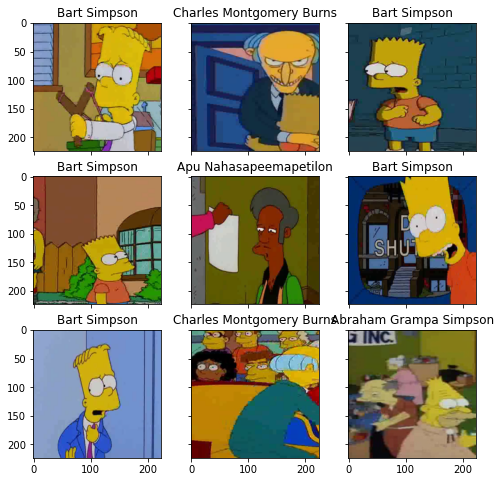

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Постороение сети

Определем некоторые функции, необходимые для обучения сети

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model = model.to(DEVICE)
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
    

In [14]:
def eval_epoch(model, val_loader, criterion):
    model = model.to(DEVICE)
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [18]:
def train(train_files, val_files, model, epochs, batch_size, pre_train=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
        

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt,  step_size=0.00002)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

Определим функцию, для получения предсказания модели.

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
n_classes = len(np.unique(train_val_labels))

In [21]:
n_classes

42

In [22]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Импортируем предобученную модель vgg16 с batchnorm

In [23]:
import torchvision.models

vgg = torchvision.models.vgg16_bn(pretrained=True)
rnxt = torchvision.models.resnext101_32x8d(pretrained=True)

In [24]:
rnxt50 = torchvision.models.resnext50_32x4d(pretrained=True)

In [25]:
rnxt50 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [26]:
for param in rnxt50.parameters():
    param.requires_grad = False
for param in rnxt50.fc.parameters():
    param.requires_grad = True
rnxt50.fc = nn.Linear(2048, n_classes)

In [27]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Замораживаем все параметры.

In [28]:
for param in vgg.parameters():
    param.requires_grad = True

Размораживаем слои классификатора

In [29]:
for param in vgg.classifier.parameters():
    param.requires_grad = True

Изменяем последний слой с учетом количества классов в нашей задаче.

In [30]:
vgg.fc = nn.Linear(4096, n_classes)

In [31]:
for param in rnxt.parameters():
    param.requires_grad = True
for param in rnxt.fc.parameters():
    param.requires_grad = True
rnxt.fc = nn.Linear(2048, n_classes)

for param in rnxt50.parameters():
    param.requires_grad = True
for param in rnxt50.fc.parameters():
    param.requires_grad = True
rnxt50.fc = nn.Linear(2048, n_classes)

In [32]:



history = train(train_dataset, val_dataset, model=rnxt50, epochs=5, batch_size=50)


label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(rnxt50, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]



my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv("e:\\labels1.csv", index=False)
my_submit.head()



epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

loss 0.5247197192710663


epoch:  20%|███████████████▏                                                            | 1/5 [05:15<21:02, 315.66s/it]


Epoch 001 train_loss: 0.5247     val_loss 0.1486 train_acc 0.8857 val_acc 0.9650
loss 0.2369687171140119


epoch:  40%|██████████████████████████████▍                                             | 2/5 [10:07<15:25, 308.46s/it]


Epoch 002 train_loss: 0.2370     val_loss 0.2570 train_acc 0.9425 val_acc 0.9429
loss 0.10143646855798671


epoch:  60%|█████████████████████████████████████████████▌                              | 3/5 [15:30<10:25, 312.77s/it]


Epoch 003 train_loss: 0.1014     val_loss 0.1718 train_acc 0.9763 val_acc 0.9620
loss 0.0711634027970438


epoch:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [22:31<05:45, 345.45s/it]


Epoch 004 train_loss: 0.0712     val_loss 0.1676 train_acc 0.9817 val_acc 0.9626
loss 0.07378493626028335


epoch: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [29:30<00:00, 354.14s/it]



Epoch 005 train_loss: 0.0738     val_loss 0.1466 train_acc 0.9811 val_acc 0.9675


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
model_resnet = torchvision.models.resnet18(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnet.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

In [ ]:
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet.fc = nn.Sequential(nn.Linear(512,42))

In [ ]:
model_resnet = model_resnet.cuda()


In [ ]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=90, batch_size=64)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]



my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv("e:\\labels.csv", index=False)
my_submit.head()


In [46]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=25, batch_size=64)

epoch:   0%|                                                                                    | 0/25 [00:00<?, ?it/s]

loss 2.1456992070654697


epoch:   4%|███                                                                        | 1/25 [01:59<47:44, 119.35s/it]


Epoch 001 train_loss: 2.1457     val_loss 1.5094 train_acc 0.4840 val_acc 0.6500
loss 1.2871129844543912


epoch:   8%|██████                                                                     | 2/25 [03:57<45:37, 119.03s/it]


Epoch 002 train_loss: 1.2871     val_loss 1.1918 train_acc 0.6924 val_acc 0.7018
loss 1.0437781047013104


epoch:  12%|█████████                                                                  | 3/25 [05:55<43:34, 118.83s/it]


Epoch 003 train_loss: 1.0438     val_loss 1.0796 train_acc 0.7378 val_acc 0.7243
loss 0.9189774154804263


epoch:  16%|████████████                                                               | 4/25 [07:54<41:32, 118.71s/it]


Epoch 004 train_loss: 0.9190     val_loss 0.9958 train_acc 0.7632 val_acc 0.7417
loss 0.8428969547713484


epoch:  20%|███████████████                                                            | 5/25 [09:52<39:32, 118.61s/it]


Epoch 005 train_loss: 0.8429     val_loss 0.9548 train_acc 0.7786 val_acc 0.7476
loss 0.77862948025478


epoch:  24%|██████████████████                                                         | 6/25 [11:50<37:30, 118.45s/it]


Epoch 006 train_loss: 0.7786     val_loss 0.9367 train_acc 0.7947 val_acc 0.7497
loss 0.7362678952638994


epoch:  28%|█████████████████████                                                      | 7/25 [13:49<35:32, 118.45s/it]


Epoch 007 train_loss: 0.7363     val_loss 0.9092 train_acc 0.8018 val_acc 0.7593
loss 0.7022871530027904


epoch:  32%|████████████████████████                                                   | 8/25 [15:47<33:31, 118.34s/it]


Epoch 008 train_loss: 0.7023     val_loss 0.8940 train_acc 0.8109 val_acc 0.7598
loss 0.6701404128236235


epoch:  36%|███████████████████████████                                                | 9/25 [17:45<31:29, 118.12s/it]


Epoch 009 train_loss: 0.6701     val_loss 0.8934 train_acc 0.8220 val_acc 0.7591
loss 0.6442771926602935


epoch:  40%|█████████████████████████████▌                                            | 10/25 [19:42<29:30, 118.01s/it]


Epoch 010 train_loss: 0.6443     val_loss 0.8754 train_acc 0.8277 val_acc 0.7650
loss 0.626524508401872


epoch:  44%|████████████████████████████████▌                                         | 11/25 [21:40<27:32, 118.01s/it]


Epoch 011 train_loss: 0.6265     val_loss 0.8740 train_acc 0.8309 val_acc 0.7616
loss 0.606878325486458


epoch:  48%|███████████████████████████████████▌                                      | 12/25 [23:38<25:33, 117.98s/it]


Epoch 012 train_loss: 0.6069     val_loss 0.8699 train_acc 0.8338 val_acc 0.7661
loss 0.5899339729991336


epoch:  52%|██████████████████████████████████████▍                                   | 13/25 [25:36<23:34, 117.87s/it]


Epoch 013 train_loss: 0.5899     val_loss 0.8637 train_acc 0.8383 val_acc 0.7673
loss 0.5726194593342818


epoch:  56%|█████████████████████████████████████████▍                                | 14/25 [27:33<21:35, 117.79s/it]


Epoch 014 train_loss: 0.5726     val_loss 0.8548 train_acc 0.8439 val_acc 0.7705
loss 0.5596547007667038


epoch:  60%|████████████████████████████████████████████▍                             | 15/25 [29:31<19:37, 117.71s/it]


Epoch 015 train_loss: 0.5597     val_loss 0.8489 train_acc 0.8478 val_acc 0.7740
loss 0.549220790911787


epoch:  64%|███████████████████████████████████████████████▎                          | 16/25 [31:29<17:39, 117.72s/it]


Epoch 016 train_loss: 0.5492     val_loss 0.8535 train_acc 0.8520 val_acc 0.7744
loss 0.5379408439338356


epoch:  68%|██████████████████████████████████████████████████▎                       | 17/25 [33:26<15:41, 117.71s/it]


Epoch 017 train_loss: 0.5379     val_loss 0.8654 train_acc 0.8519 val_acc 0.7671
loss 0.5254550292500417


epoch:  72%|█████████████████████████████████████████████████████▎                    | 18/25 [35:24<13:43, 117.66s/it]


Epoch 018 train_loss: 0.5255     val_loss 0.8451 train_acc 0.8565 val_acc 0.7724
loss 0.5188125191342186


epoch:  76%|████████████████████████████████████████████████████████▏                 | 19/25 [37:21<11:45, 117.64s/it]


Epoch 019 train_loss: 0.5188     val_loss 0.8339 train_acc 0.8601 val_acc 0.7799
loss 0.5065387573293215


epoch:  80%|███████████████████████████████████████████████████████████▏              | 20/25 [39:20<09:49, 118.00s/it]


Epoch 020 train_loss: 0.5065     val_loss 0.8497 train_acc 0.8643 val_acc 0.7747
loss 0.49919589723900737


epoch:  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [41:21<07:55, 118.80s/it]


Epoch 021 train_loss: 0.4992     val_loss 0.8403 train_acc 0.8638 val_acc 0.7812
loss 0.491421541933634


epoch:  88%|█████████████████████████████████████████████████████████████████         | 22/25 [43:22<05:58, 119.42s/it]


Epoch 022 train_loss: 0.4914     val_loss 0.8497 train_acc 0.8676 val_acc 0.7746
loss 0.4853542527922233


epoch:  92%|████████████████████████████████████████████████████████████████████      | 23/25 [45:21<03:58, 119.43s/it]


Epoch 023 train_loss: 0.4854     val_loss 0.8418 train_acc 0.8694 val_acc 0.7795
loss 0.47677275771373046


epoch:  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [47:20<01:59, 119.26s/it]


Epoch 024 train_loss: 0.4768     val_loss 0.8506 train_acc 0.8698 val_acc 0.7780
loss 0.46944782616826514


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [49:20<00:00, 118.43s/it]


Epoch 025 train_loss: 0.4694     val_loss 0.8551 train_acc 0.8708 val_acc 0.7736


In [47]:
import copy

# сохранить веса нашей нейросети model
model_pre_weights = copy.deepcopy(model_resnet.state_dict())

In [48]:
for child in model_resnet.children():
    for param in child.parameters():
        param.requires_grad = True

In [49]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=50, batch_size=64)

epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

loss 3.8755884982725717


epoch:   2%|█▍                                                                       | 1/50 [02:15<1:50:48, 135.69s/it]


Epoch 001 train_loss: 3.8756     val_loss 3.1130 train_acc 0.1020 val_acc 0.1074
loss 3.1205559292449503


epoch:   4%|██▉                                                                      | 2/50 [04:33<1:49:00, 136.26s/it]


Epoch 002 train_loss: 3.1206     val_loss 3.1113 train_acc 0.1069 val_acc 0.1074
loss 3.1190991041439946


epoch:   6%|████▍                                                                    | 3/50 [06:51<1:47:14, 136.91s/it]


Epoch 003 train_loss: 3.1191     val_loss 3.1116 train_acc 0.1070 val_acc 0.1074
loss 3.1140854311138213


epoch:   8%|█████▊                                                                   | 4/50 [09:08<1:44:58, 136.93s/it]


Epoch 004 train_loss: 3.1141     val_loss 3.1023 train_acc 0.1061 val_acc 0.1100
loss 3.0246054800887556


epoch:  10%|███████▎                                                                 | 5/50 [11:26<1:42:52, 137.17s/it]


Epoch 005 train_loss: 3.0246     val_loss 2.9402 train_acc 0.1355 val_acc 0.1511
loss 2.7493503018696375


epoch:  12%|████████▊                                                                | 6/50 [13:43<1:40:29, 137.04s/it]


Epoch 006 train_loss: 2.7494     val_loss 2.5473 train_acc 0.2224 val_acc 0.2789
loss 2.14266231963039


epoch:  14%|██████████▏                                                              | 7/50 [15:59<1:38:05, 136.87s/it]


Epoch 007 train_loss: 2.1427     val_loss 1.8483 train_acc 0.4027 val_acc 0.4771
loss 1.3813606937361853


epoch:  16%|███████████▋                                                             | 8/50 [18:16<1:35:44, 136.78s/it]


Epoch 008 train_loss: 1.3814     val_loss 1.1782 train_acc 0.6193 val_acc 0.6714
loss 0.9369118316772371


epoch:  18%|█████████████▏                                                           | 9/50 [20:32<1:33:24, 136.69s/it]


Epoch 009 train_loss: 0.9369     val_loss 0.8998 train_acc 0.7385 val_acc 0.7593
loss 0.7087913734592886


epoch:  20%|██████████████▍                                                         | 10/50 [22:49<1:31:03, 136.60s/it]


Epoch 010 train_loss: 0.7088     val_loss 0.7854 train_acc 0.7970 val_acc 0.7874
loss 0.5256362741020381


epoch:  22%|███████████████▊                                                        | 11/50 [25:06<1:28:53, 136.76s/it]


Epoch 011 train_loss: 0.5256     val_loss 0.7275 train_acc 0.8502 val_acc 0.8097
loss 0.41391894067823604


epoch:  24%|█████████████████▎                                                      | 12/50 [27:22<1:26:32, 136.65s/it]


Epoch 012 train_loss: 0.4139     val_loss 0.5954 train_acc 0.8802 val_acc 0.8433
loss 0.33222838873673083


epoch:  26%|██████████████████▋                                                     | 13/50 [29:40<1:24:29, 137.01s/it]


Epoch 013 train_loss: 0.3322     val_loss 0.6230 train_acc 0.9003 val_acc 0.8397
loss 0.29150308367960986


epoch:  28%|████████████████████▏                                                   | 14/50 [31:58<1:22:19, 137.21s/it]


Epoch 014 train_loss: 0.2915     val_loss 0.6778 train_acc 0.9113 val_acc 0.8286
loss 0.22384526657028497


epoch:  30%|█████████████████████▌                                                  | 15/50 [34:14<1:19:52, 136.94s/it]


Epoch 015 train_loss: 0.2238     val_loss 0.6221 train_acc 0.9301 val_acc 0.8540
loss 0.18843826807428374


epoch:  32%|███████████████████████                                                 | 16/50 [36:30<1:17:27, 136.70s/it]


Epoch 016 train_loss: 0.1884     val_loss 0.6750 train_acc 0.9429 val_acc 0.8437
loss 0.16610765135096883


epoch:  34%|████████████████████████▍                                               | 17/50 [38:47<1:15:10, 136.67s/it]


Epoch 017 train_loss: 0.1661     val_loss 0.6839 train_acc 0.9483 val_acc 0.8519
loss 0.16040586509796242


epoch:  36%|█████████████████████████▉                                              | 18/50 [41:05<1:13:05, 137.04s/it]


Epoch 018 train_loss: 0.1604     val_loss 0.7027 train_acc 0.9513 val_acc 0.8573
loss 0.15383001739595017


epoch:  38%|███████████████████████████▎                                            | 19/50 [43:24<1:11:08, 137.70s/it]


Epoch 019 train_loss: 0.1538     val_loss 0.8536 train_acc 0.9531 val_acc 0.8280
loss 0.14120715864335392


epoch:  40%|████████████████████████████▊                                           | 20/50 [45:46<1:09:27, 138.91s/it]


Epoch 020 train_loss: 0.1412     val_loss 0.7320 train_acc 0.9578 val_acc 0.8579
loss 0.11324018535276428


epoch:  42%|██████████████████████████████▏                                         | 21/50 [48:07<1:07:33, 139.79s/it]


Epoch 021 train_loss: 0.1132     val_loss 0.6803 train_acc 0.9664 val_acc 0.8607
loss 0.07591561041285912


epoch:  44%|███████████████████████████████▋                                        | 22/50 [50:24<1:04:51, 138.98s/it]


Epoch 022 train_loss: 0.0759     val_loss 0.7010 train_acc 0.9779 val_acc 0.8747
loss 0.10346319804401016


epoch:  46%|█████████████████████████████████                                       | 23/50 [52:41<1:02:14, 138.33s/it]


Epoch 023 train_loss: 0.1035     val_loss 0.7352 train_acc 0.9696 val_acc 0.8724
loss 0.13454466975887944


epoch:  48%|███████████████████████████████████▌                                      | 24/50 [54:58<59:47, 137.97s/it]


Epoch 024 train_loss: 0.1345     val_loss 0.7479 train_acc 0.9608 val_acc 0.8546
loss 0.07982108098028176


epoch:  50%|█████████████████████████████████████                                     | 25/50 [57:17<57:36, 138.28s/it]


Epoch 025 train_loss: 0.0798     val_loss 0.6925 train_acc 0.9757 val_acc 0.8743
loss 0.07982931357142621


epoch:  52%|██████████████████████████████████████▍                                   | 26/50 [59:38<55:31, 138.83s/it]


Epoch 026 train_loss: 0.0798     val_loss 0.7512 train_acc 0.9782 val_acc 0.8592
loss 0.08643893779740303


epoch:  54%|██████████████████████████████████████▉                                 | 27/50 [1:02:02<53:50, 140.45s/it]


Epoch 027 train_loss: 0.0864     val_loss 0.7699 train_acc 0.9745 val_acc 0.8571
loss 0.07469291403449237


epoch:  56%|████████████████████████████████████████▎                               | 28/50 [1:04:26<51:52, 141.48s/it]


Epoch 028 train_loss: 0.0747     val_loss 0.7088 train_acc 0.9778 val_acc 0.8712
loss 0.08783914446072592


epoch:  58%|█████████████████████████████████████████▊                              | 29/50 [1:06:43<49:05, 140.28s/it]


Epoch 029 train_loss: 0.0878     val_loss 0.7239 train_acc 0.9740 val_acc 0.8777
loss 0.07435640821561926


epoch:  60%|███████████████████████████████████████████▏                            | 30/50 [1:09:01<46:28, 139.44s/it]


Epoch 030 train_loss: 0.0744     val_loss 0.7969 train_acc 0.9780 val_acc 0.8588
loss 0.07312094003125372


epoch:  62%|████████████████████████████████████████████▋                           | 31/50 [1:11:18<43:57, 138.84s/it]


Epoch 031 train_loss: 0.0731     val_loss 0.6929 train_acc 0.9791 val_acc 0.8796
loss 0.057461510405691425


epoch:  64%|██████████████████████████████████████████████                          | 32/50 [1:13:35<41:31, 138.41s/it]


Epoch 032 train_loss: 0.0575     val_loss 0.7214 train_acc 0.9832 val_acc 0.8766
loss 0.06872630153428919


epoch:  66%|███████████████████████████████████████████████▌                        | 33/50 [1:15:51<38:59, 137.63s/it]


Epoch 033 train_loss: 0.0687     val_loss 0.8743 train_acc 0.9811 val_acc 0.8462
loss 0.06300349246787185


epoch:  68%|████████████████████████████████████████████████▉                       | 34/50 [1:18:06<36:30, 136.90s/it]


Epoch 034 train_loss: 0.0630     val_loss 0.7790 train_acc 0.9801 val_acc 0.8731
loss 0.06366366362100116


epoch:  70%|██████████████████████████████████████████████████▍                     | 35/50 [1:20:22<34:07, 136.48s/it]


Epoch 035 train_loss: 0.0637     val_loss 0.7879 train_acc 0.9812 val_acc 0.8609
loss 0.11581797777746182


epoch:  72%|███████████████████████████████████████████████████▊                    | 36/50 [1:22:37<31:43, 136.00s/it]


Epoch 036 train_loss: 0.1158     val_loss 0.8972 train_acc 0.9665 val_acc 0.8489
loss 0.054879246631624044


epoch:  74%|█████████████████████████████████████████████████████▎                  | 37/50 [1:24:51<29:22, 135.58s/it]


Epoch 037 train_loss: 0.0549     val_loss 0.8203 train_acc 0.9842 val_acc 0.8657
loss 0.06860749336250596


epoch:  76%|██████████████████████████████████████████████████████▋                 | 38/50 [1:27:06<27:04, 135.35s/it]


Epoch 038 train_loss: 0.0686     val_loss 0.6926 train_acc 0.9799 val_acc 0.8741
loss 0.043651029778967176


epoch:  78%|████████████████████████████████████████████████████████▏               | 39/50 [1:29:21<24:48, 135.32s/it]


Epoch 039 train_loss: 0.0437     val_loss 0.7604 train_acc 0.9871 val_acc 0.8764
loss 0.05489432155154349


epoch:  80%|█████████████████████████████████████████████████████████▌              | 40/50 [1:31:38<22:37, 135.72s/it]


Epoch 040 train_loss: 0.0549     val_loss 0.7366 train_acc 0.9831 val_acc 0.8684
loss 0.061374426699609574


epoch:  82%|███████████████████████████████████████████████████████████             | 41/50 [1:33:55<20:23, 135.92s/it]


Epoch 041 train_loss: 0.0614     val_loss 0.8099 train_acc 0.9815 val_acc 0.8619
loss 0.0407412359640783


epoch:  84%|████████████████████████████████████████████████████████████▍           | 42/50 [1:36:12<18:11, 136.46s/it]


Epoch 042 train_loss: 0.0407     val_loss 0.8156 train_acc 0.9886 val_acc 0.8833
loss 0.05190270905083287


epoch:  86%|█████████████████████████████████████████████████████████████▉          | 43/50 [1:38:30<15:58, 136.87s/it]


Epoch 043 train_loss: 0.0519     val_loss 1.0534 train_acc 0.9851 val_acc 0.8401
loss 0.0634341038392394


epoch:  88%|███████████████████████████████████████████████████████████████▎        | 44/50 [1:40:48<13:43, 137.22s/it]


Epoch 044 train_loss: 0.0634     val_loss 0.7662 train_acc 0.9820 val_acc 0.8863
loss 0.016676689100368597


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 45/50 [1:43:06<11:26, 137.36s/it]


Epoch 045 train_loss: 0.0167     val_loss 0.8559 train_acc 0.9948 val_acc 0.8729
loss 0.044985263103744275


epoch:  92%|██████████████████████████████████████████████████████████████████▏     | 46/50 [1:45:24<09:10, 137.52s/it]


Epoch 046 train_loss: 0.0450     val_loss 0.7818 train_acc 0.9870 val_acc 0.8770
loss 0.06330927017958958


epoch:  94%|███████████████████████████████████████████████████████████████████▋    | 47/50 [1:47:42<06:53, 137.70s/it]


Epoch 047 train_loss: 0.0633     val_loss 0.7152 train_acc 0.9818 val_acc 0.8819
loss 0.03467413551371415


epoch:  96%|█████████████████████████████████████████████████████████████████████   | 48/50 [1:50:02<04:36, 138.46s/it]


Epoch 048 train_loss: 0.0347     val_loss 0.7853 train_acc 0.9905 val_acc 0.8766
loss 0.03836014372324454


epoch:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [1:52:21<02:18, 138.67s/it]


Epoch 049 train_loss: 0.0384     val_loss 0.8904 train_acc 0.9892 val_acc 0.8731
loss 0.052642741503661564


epoch: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [1:54:40<00:00, 137.62s/it]


Epoch 050 train_loss: 0.0526     val_loss 0.6942 train_acc 0.9845 val_acc 0.8806


Обучать в данной модели будем только последнии слои, которые выполняют функцию классификатора. 

In [32]:
for child in model_resnet.children():
    for param in child.parameters():
        param.requires_grad = True

In [33]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=50, batch_size=64)

epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

loss 0.6266241207022626


epoch:   2%|█▍                                                                       | 1/50 [02:18<1:53:18, 138.75s/it]


Epoch 001 train_loss: 0.6266     val_loss 0.5429 train_acc 0.8451 val_acc 0.8615
loss 3.1489556690592457


epoch:   4%|██▉                                                                      | 2/50 [04:35<1:50:37, 138.27s/it]


Epoch 002 train_loss: 3.1490     val_loss 3.1091 train_acc 0.1092 val_acc 0.1074
loss 3.114500537481465


epoch:   6%|████▍                                                                    | 3/50 [06:54<1:48:22, 138.36s/it]


Epoch 003 train_loss: 3.1145     val_loss 3.1117 train_acc 0.1073 val_acc 0.1074
loss 3.1112815022536906


epoch:   8%|█████▊                                                                   | 4/50 [09:10<1:45:38, 137.80s/it]


Epoch 004 train_loss: 3.1113     val_loss 3.0968 train_acc 0.1071 val_acc 0.1122
loss 2.8691961838186253


epoch:  10%|███████▎                                                                 | 5/50 [11:27<1:43:01, 137.37s/it]


Epoch 005 train_loss: 2.8692     val_loss 2.6575 train_acc 0.1780 val_acc 0.2308
loss 2.16707685343953


epoch:  12%|████████▊                                                                | 6/50 [13:43<1:40:32, 137.10s/it]


Epoch 006 train_loss: 2.1671     val_loss 2.1306 train_acc 0.3863 val_acc 0.4306
loss 1.6635380061889684


epoch:  14%|██████████▏                                                              | 7/50 [16:00<1:38:08, 136.93s/it]


Epoch 007 train_loss: 1.6635     val_loss 1.6268 train_acc 0.5316 val_acc 0.5443
loss 1.3001001822856575


epoch:  16%|███████████▋                                                             | 8/50 [18:16<1:35:45, 136.80s/it]


Epoch 008 train_loss: 1.3001     val_loss 1.2091 train_acc 0.6320 val_acc 0.6693
loss 1.044783101213822


epoch:  18%|█████████████▏                                                           | 9/50 [20:33<1:33:27, 136.77s/it]


Epoch 009 train_loss: 1.0448     val_loss 1.0836 train_acc 0.7037 val_acc 0.7084
loss 0.837918158739006


epoch:  20%|██████████████▍                                                         | 10/50 [22:50<1:31:09, 136.73s/it]


Epoch 010 train_loss: 0.8379     val_loss 1.0124 train_acc 0.7597 val_acc 0.7310
loss 0.6544448816041232


epoch:  22%|███████████████▊                                                        | 11/50 [25:06<1:28:46, 136.58s/it]


Epoch 011 train_loss: 0.6544     val_loss 0.8892 train_acc 0.8118 val_acc 0.7661
loss 0.5010623423960097


epoch:  24%|█████████████████▎                                                      | 12/50 [27:22<1:26:25, 136.45s/it]


Epoch 012 train_loss: 0.5011     val_loss 0.9081 train_acc 0.8548 val_acc 0.7784
loss 0.3859651130867639


epoch:  26%|██████████████████▋                                                     | 13/50 [29:38<1:24:04, 136.34s/it]


Epoch 013 train_loss: 0.3860     val_loss 0.9027 train_acc 0.8850 val_acc 0.7929
loss 0.2725758070021885


epoch:  28%|████████████████████▏                                                   | 14/50 [31:54<1:21:47, 136.33s/it]


Epoch 014 train_loss: 0.2726     val_loss 0.9230 train_acc 0.9168 val_acc 0.8000
loss 0.21182073842508906


epoch:  30%|█████████████████████▌                                                  | 15/50 [34:11<1:19:30, 136.30s/it]


Epoch 015 train_loss: 0.2118     val_loss 1.0074 train_acc 0.9359 val_acc 0.7965
loss 0.17824491983109564


epoch:  32%|███████████████████████                                                 | 16/50 [36:27<1:17:12, 136.26s/it]


Epoch 016 train_loss: 0.1782     val_loss 1.0121 train_acc 0.9422 val_acc 0.7845
loss 0.13630414825340723


epoch:  34%|████████████████████████▍                                               | 17/50 [38:43<1:14:58, 136.32s/it]


Epoch 017 train_loss: 0.1363     val_loss 1.0953 train_acc 0.9590 val_acc 0.8003
loss 0.10529919026719817


epoch:  36%|█████████████████████████▉                                              | 18/50 [41:02<1:13:00, 136.89s/it]


Epoch 018 train_loss: 0.1053     val_loss 1.1200 train_acc 0.9659 val_acc 0.8078
loss 0.10919305164405164


epoch:  38%|███████████████████████████▎                                            | 19/50 [43:19<1:10:51, 137.15s/it]


Epoch 019 train_loss: 0.1092     val_loss 1.1439 train_acc 0.9661 val_acc 0.8044


epoch:  38%|███████████████████████████▎                                            | 19/50 [44:51<1:13:10, 141.63s/it]


KeyboardInterrupt: 

In [31]:
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet.fc = nn.Sequential(nn.Linear(512,42))

In [ ]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=50, batch_size=64)

epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

loss 1.0565977375995916


epoch:   2%|█▍                                                                       | 1/50 [02:03<1:40:40, 123.28s/it]


Epoch 001 train_loss: 1.0566     val_loss 1.0678 train_acc 0.7332 val_acc 0.7214
loss 0.9057391930844452


epoch:   4%|██▉                                                                      | 2/50 [04:05<1:38:19, 122.90s/it]


Epoch 002 train_loss: 0.9057     val_loss 1.0008 train_acc 0.7646 val_acc 0.7346
loss 0.8222020943344486


epoch:   6%|████▍                                                                    | 3/50 [06:15<1:37:56, 125.02s/it]


Epoch 003 train_loss: 0.8222     val_loss 0.9531 train_acc 0.7823 val_acc 0.7484
loss 0.7619480728093162


epoch:   8%|█████▊                                                                   | 4/50 [08:22<1:36:21, 125.69s/it]


Epoch 004 train_loss: 0.7619     val_loss 0.9206 train_acc 0.8001 val_acc 0.7541
loss 0.7188648981261051


epoch:  10%|███████▎                                                                 | 5/50 [10:23<1:33:07, 124.17s/it]


Epoch 005 train_loss: 0.7189     val_loss 0.8944 train_acc 0.8091 val_acc 0.7581
loss 0.6835893542229412


epoch:  12%|████████▊                                                                | 6/50 [12:22<1:30:00, 122.74s/it]


Epoch 006 train_loss: 0.6836     val_loss 0.8761 train_acc 0.8166 val_acc 0.7606
loss 0.6567743268124776


epoch:  14%|██████████▏                                                              | 7/50 [14:22<1:27:15, 121.77s/it]


Epoch 007 train_loss: 0.6568     val_loss 0.8793 train_acc 0.8256 val_acc 0.7623
loss 0.6329912861651452


epoch:  16%|███████████▋                                                             | 8/50 [16:22<1:24:53, 121.28s/it]


Epoch 008 train_loss: 0.6330     val_loss 0.8790 train_acc 0.8278 val_acc 0.7585
loss 0.612430779793375


epoch:  18%|█████████████▏                                                           | 9/50 [18:22<1:22:37, 120.91s/it]


Epoch 009 train_loss: 0.6124     val_loss 0.8414 train_acc 0.8357 val_acc 0.7703


In [46]:
#history = train(train_dataset, val_dataset, model=vgg, epochs=5, batch_size=64)


epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

loss 2.3532303993098562


epoch:  20%|███████████████▏                                                            | 1/5 [03:00<12:01, 180.42s/it]


Epoch 001 train_loss: 2.3532     val_loss 1.0447 train_acc 0.4049 val_acc 0.7392
loss 0.5646945716347753


epoch:  40%|██████████████████████████████▍                                             | 2/5 [05:57<08:58, 179.44s/it]


Epoch 002 train_loss: 0.5647     val_loss 0.6618 train_acc 0.8500 val_acc 0.8261
loss 0.07562187531816698


epoch:  60%|█████████████████████████████████████████████▌                              | 3/5 [08:51<05:55, 177.80s/it]


Epoch 003 train_loss: 0.0756     val_loss 0.8568 train_acc 0.9796 val_acc 0.8170
loss 0.01908964394859358


epoch:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [11:43<02:56, 176.00s/it]


Epoch 004 train_loss: 0.0191     val_loss 0.8675 train_acc 0.9955 val_acc 0.8229
loss 0.011026365557621187


epoch: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [14:34<00:00, 174.95s/it]


Epoch 005 train_loss: 0.0110     val_loss 0.8580 train_acc 0.9974 val_acc 0.8198


In [ ]:
history = train(train_dataset, val_dataset, model=rnxt, epochs=5, batch_size=64)

epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

loss 1.7213408381735886


epoch:  20%|███████████████▏                                                            | 1/5 [04:00<16:00, 240.04s/it]


Epoch 001 train_loss: 1.7213     val_loss 1.1367 train_acc 0.5931 val_acc 0.7197
loss 0.9220855420535898


epoch:  40%|██████████████████████████████▍                                             | 2/5 [07:56<11:57, 239.06s/it]


Epoch 002 train_loss: 0.9221     val_loss 0.9349 train_acc 0.7670 val_acc 0.7646
loss 0.7315791403687648


epoch:  60%|█████████████████████████████████████████████▌                              | 3/5 [12:50<08:30, 255.44s/it]


Epoch 003 train_loss: 0.7316     val_loss 0.8370 train_acc 0.8095 val_acc 0.7860


In [ ]:
history = train(train_dataset, val_dataset, model=rnxt, epochs=50, batch_size=64)

In [26]:
history = train(train_dataset, val_dataset, model=rnxt50, epochs=50, batch_size=64)

epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

loss 1.6312202629872026


epoch:   2%|█▍                                                                       | 1/50 [02:26<1:59:42, 146.58s/it]


Epoch 001 train_loss: 1.6312     val_loss 1.3086 train_acc 0.6062 val_acc 0.6632
loss 1.0833895719311817


epoch:   4%|██▉                                                                      | 2/50 [04:50<1:56:39, 145.83s/it]


Epoch 002 train_loss: 1.0834     val_loss 1.1361 train_acc 0.7230 val_acc 0.6947
loss 0.8923971128734072


epoch:   6%|████▍                                                                    | 3/50 [07:15<1:53:53, 145.38s/it]


Epoch 003 train_loss: 0.8924     val_loss 1.0219 train_acc 0.7630 val_acc 0.7228
loss 0.7830653422402306


epoch:   8%|█████▊                                                                   | 4/50 [10:25<2:01:48, 158.89s/it]


Epoch 004 train_loss: 0.7831     val_loss 0.9796 train_acc 0.7906 val_acc 0.7268
loss 0.7124496080046345


epoch:  10%|███████▎                                                                 | 5/50 [12:57<1:57:35, 156.78s/it]


Epoch 005 train_loss: 0.7124     val_loss 0.9482 train_acc 0.8057 val_acc 0.7388
loss 0.6624598184198139


epoch:  12%|████████▊                                                                | 6/50 [15:34<1:55:10, 157.07s/it]


Epoch 006 train_loss: 0.6625     val_loss 0.9186 train_acc 0.8188 val_acc 0.7472
loss 0.614097520529643


epoch:  14%|██████████▏                                                              | 7/50 [18:16<1:53:37, 158.55s/it]


Epoch 007 train_loss: 0.6141     val_loss 0.9206 train_acc 0.8316 val_acc 0.7461
loss 0.5780855199168219


epoch:  16%|███████████▋                                                             | 8/50 [20:58<1:51:35, 159.41s/it]


Epoch 008 train_loss: 0.5781     val_loss 0.8944 train_acc 0.8413 val_acc 0.7553
loss 0.5430636395465888


epoch:  18%|█████████████▏                                                           | 9/50 [23:40<1:49:25, 160.15s/it]


Epoch 009 train_loss: 0.5431     val_loss 0.8870 train_acc 0.8539 val_acc 0.7535
loss 0.5170986764244505


epoch:  20%|██████████████▍                                                         | 10/50 [26:20<1:46:52, 160.31s/it]


Epoch 010 train_loss: 0.5171     val_loss 0.8772 train_acc 0.8587 val_acc 0.7535
loss 0.4897107093742269


epoch:  22%|███████████████▊                                                        | 11/50 [29:03<1:44:35, 160.92s/it]


Epoch 011 train_loss: 0.4897     val_loss 0.8615 train_acc 0.8675 val_acc 0.7618
loss 0.4733717509406153


epoch:  24%|█████████████████▎                                                      | 12/50 [31:46<1:42:18, 161.54s/it]


Epoch 012 train_loss: 0.4734     val_loss 0.8995 train_acc 0.8715 val_acc 0.7537
loss 0.45267709066468564


epoch:  26%|██████████████████▋                                                     | 13/50 [34:30<1:40:02, 162.23s/it]


Epoch 013 train_loss: 0.4527     val_loss 0.8657 train_acc 0.8763 val_acc 0.7608
loss 0.43062754514809815


epoch:  28%|████████████████████▏                                                   | 14/50 [37:10<1:37:00, 161.67s/it]


Epoch 014 train_loss: 0.4306     val_loss 0.8843 train_acc 0.8826 val_acc 0.7604
loss 0.4182810934837232


epoch:  30%|█████████████████████▌                                                  | 15/50 [39:50<1:34:02, 161.21s/it]


Epoch 015 train_loss: 0.4183     val_loss 0.8846 train_acc 0.8885 val_acc 0.7633
loss 0.4055487447450841


epoch:  32%|███████████████████████                                                 | 16/50 [42:31<1:31:19, 161.17s/it]


Epoch 016 train_loss: 0.4055     val_loss 0.8696 train_acc 0.8909 val_acc 0.7650
loss 0.3858811286852856


epoch:  34%|████████████████████████▍                                               | 17/50 [45:13<1:28:47, 161.45s/it]


Epoch 017 train_loss: 0.3859     val_loss 0.8613 train_acc 0.8971 val_acc 0.7715
loss 0.37380106848617656


epoch:  36%|█████████████████████████▉                                              | 18/50 [47:57<1:26:27, 162.09s/it]


Epoch 018 train_loss: 0.3738     val_loss 0.8518 train_acc 0.8991 val_acc 0.7768
loss 0.3601842426507289


epoch:  38%|███████████████████████████▎                                            | 19/50 [50:36<1:23:19, 161.28s/it]


Epoch 019 train_loss: 0.3602     val_loss 0.8472 train_acc 0.9031 val_acc 0.7709
loss 0.3506504176653785


epoch:  40%|████████████████████████████▊                                           | 20/50 [53:00<1:18:01, 156.06s/it]


Epoch 020 train_loss: 0.3507     val_loss 0.8734 train_acc 0.9066 val_acc 0.7705
loss 0.3338213403370435


epoch:  42%|██████████████████████████████▏                                         | 21/50 [55:24<1:13:41, 152.45s/it]


Epoch 021 train_loss: 0.3338     val_loss 0.8444 train_acc 0.9146 val_acc 0.7786
loss 0.3244652005403814


epoch:  44%|███████████████████████████████▋                                        | 22/50 [57:48<1:09:57, 149.90s/it]


Epoch 022 train_loss: 0.3245     val_loss 0.8858 train_acc 0.9170 val_acc 0.7661
loss 0.31609036131845675


epoch:  46%|████████████████████████████████▏                                     | 23/50 [1:00:12<1:06:40, 148.18s/it]


Epoch 023 train_loss: 0.3161     val_loss 0.8507 train_acc 0.9164 val_acc 0.7780
loss 0.3050520760051399


epoch:  48%|█████████████████████████████████▌                                    | 24/50 [1:02:37<1:03:42, 147.02s/it]


Epoch 024 train_loss: 0.3051     val_loss 0.8468 train_acc 0.9255 val_acc 0.7786
loss 0.2947405324566022


epoch:  50%|███████████████████████████████████                                   | 25/50 [1:05:01<1:00:54, 146.18s/it]


Epoch 025 train_loss: 0.2947     val_loss 0.8624 train_acc 0.9271 val_acc 0.7761
loss 0.2895707824088349


epoch:  52%|█████████████████████████████████████▍                                  | 26/50 [1:07:26<58:18, 145.78s/it]


Epoch 026 train_loss: 0.2896     val_loss 0.8514 train_acc 0.9263 val_acc 0.7797
loss 0.2823615055439905


epoch:  54%|██████████████████████████████████████▉                                 | 27/50 [1:09:51<55:52, 145.78s/it]


Epoch 027 train_loss: 0.2824     val_loss 0.8983 train_acc 0.9289 val_acc 0.7675
loss 0.2721422754512394


epoch:  56%|████████████████████████████████████████▎                               | 28/50 [1:12:15<53:15, 145.24s/it]


Epoch 028 train_loss: 0.2721     val_loss 0.8624 train_acc 0.9310 val_acc 0.7814
loss 0.2689346423729399


epoch:  58%|█████████████████████████████████████████▊                              | 29/50 [1:14:40<50:45, 145.04s/it]


Epoch 029 train_loss: 0.2689     val_loss 0.8876 train_acc 0.9306 val_acc 0.7709
loss 0.25739489324617265


epoch:  60%|███████████████████████████████████████████▏                            | 30/50 [1:17:05<48:18, 144.90s/it]


Epoch 030 train_loss: 0.2574     val_loss 0.8943 train_acc 0.9373 val_acc 0.7684
loss 0.25102756290828676


epoch:  62%|████████████████████████████████████████████▋                           | 31/50 [1:19:31<46:01, 145.34s/it]


Epoch 031 train_loss: 0.2510     val_loss 0.8772 train_acc 0.9390 val_acc 0.7755
loss 0.2455596449001328


epoch:  64%|██████████████████████████████████████████████                          | 32/50 [1:22:04<44:15, 147.53s/it]


Epoch 032 train_loss: 0.2456     val_loss 0.9184 train_acc 0.9411 val_acc 0.7692
loss 0.2395555383271112


epoch:  66%|███████████████████████████████████████████████▌                        | 33/50 [1:24:32<41:51, 147.75s/it]


Epoch 033 train_loss: 0.2396     val_loss 0.9142 train_acc 0.9410 val_acc 0.7719
loss 0.23386235564094765


epoch:  68%|████████████████████████████████████████████████▉                       | 34/50 [1:27:01<39:29, 148.10s/it]


Epoch 034 train_loss: 0.2339     val_loss 0.9272 train_acc 0.9437 val_acc 0.7631
loss 0.22576791982231903


epoch:  70%|██████████████████████████████████████████████████▍                     | 35/50 [1:29:31<37:11, 148.75s/it]


Epoch 035 train_loss: 0.2258     val_loss 0.8816 train_acc 0.9460 val_acc 0.7824
loss 0.22664180691093844


epoch:  72%|███████████████████████████████████████████████████▊                    | 36/50 [1:32:01<34:46, 149.01s/it]


Epoch 036 train_loss: 0.2266     val_loss 0.9037 train_acc 0.9455 val_acc 0.7788
loss 0.21919356905105683


epoch:  74%|█████████████████████████████████████████████████████▎                  | 37/50 [1:34:30<32:19, 149.16s/it]


Epoch 037 train_loss: 0.2192     val_loss 0.9037 train_acc 0.9483 val_acc 0.7749
loss 0.21111467099564116


epoch:  76%|██████████████████████████████████████████████████████▋                 | 38/50 [1:37:00<29:52, 149.35s/it]


Epoch 038 train_loss: 0.2111     val_loss 0.9184 train_acc 0.9502 val_acc 0.7810
loss 0.208599846618131


epoch:  78%|████████████████████████████████████████████████████████▏               | 39/50 [1:39:31<27:29, 149.96s/it]


Epoch 039 train_loss: 0.2086     val_loss 0.8932 train_acc 0.9509 val_acc 0.7816
loss 0.20151292100758514


epoch:  80%|█████████████████████████████████████████████████████████▌              | 40/50 [1:42:05<25:10, 151.07s/it]


Epoch 040 train_loss: 0.2015     val_loss 0.9210 train_acc 0.9543 val_acc 0.7761
loss 0.1962381988741029


epoch:  82%|███████████████████████████████████████████████████████████             | 41/50 [1:44:38<22:45, 151.71s/it]


Epoch 041 train_loss: 0.1962     val_loss 0.8937 train_acc 0.9565 val_acc 0.7831
loss 0.19007963163471958


epoch:  84%|████████████████████████████████████████████████████████████▍           | 42/50 [1:47:11<20:16, 152.11s/it]


Epoch 042 train_loss: 0.1901     val_loss 0.9232 train_acc 0.9571 val_acc 0.7713
loss 0.188234114996779


epoch:  86%|█████████████████████████████████████████████████████████████▉          | 43/50 [1:49:44<17:46, 152.36s/it]


Epoch 043 train_loss: 0.1882     val_loss 0.9377 train_acc 0.9580 val_acc 0.7746
loss 0.18384140655156328


epoch:  88%|███████████████████████████████████████████████████████████████▎        | 44/50 [1:52:18<15:16, 152.74s/it]


Epoch 044 train_loss: 0.1838     val_loss 0.9331 train_acc 0.9597 val_acc 0.7749
loss 0.17659652685882166


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 45/50 [1:54:53<12:46, 153.32s/it]


Epoch 045 train_loss: 0.1766     val_loss 0.9173 train_acc 0.9634 val_acc 0.7772
loss 0.17649300290988626


epoch:  92%|██████████████████████████████████████████████████████████████████▏     | 46/50 [1:57:28<10:16, 154.02s/it]


Epoch 046 train_loss: 0.1765     val_loss 0.9664 train_acc 0.9627 val_acc 0.7696
loss 0.1752818786720727


epoch:  94%|███████████████████████████████████████████████████████████████████▋    | 47/50 [2:00:04<07:43, 154.43s/it]


Epoch 047 train_loss: 0.1753     val_loss 0.9184 train_acc 0.9626 val_acc 0.7824
loss 0.16476403441368162


epoch:  96%|█████████████████████████████████████████████████████████████████████   | 48/50 [2:02:39<05:09, 154.65s/it]


Epoch 048 train_loss: 0.1648     val_loss 0.9296 train_acc 0.9662 val_acc 0.7768
loss 0.1636537962386514


epoch:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [2:05:13<02:34, 154.52s/it]


Epoch 049 train_loss: 0.1637     val_loss 0.9465 train_acc 0.9650 val_acc 0.7757
loss 0.1599572769530116


epoch: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [2:07:46<00:00, 153.33s/it]


Epoch 050 train_loss: 0.1600     val_loss 0.9339 train_acc 0.9678 val_acc 0.7807


Смотрим на изменение лосса по эпохам

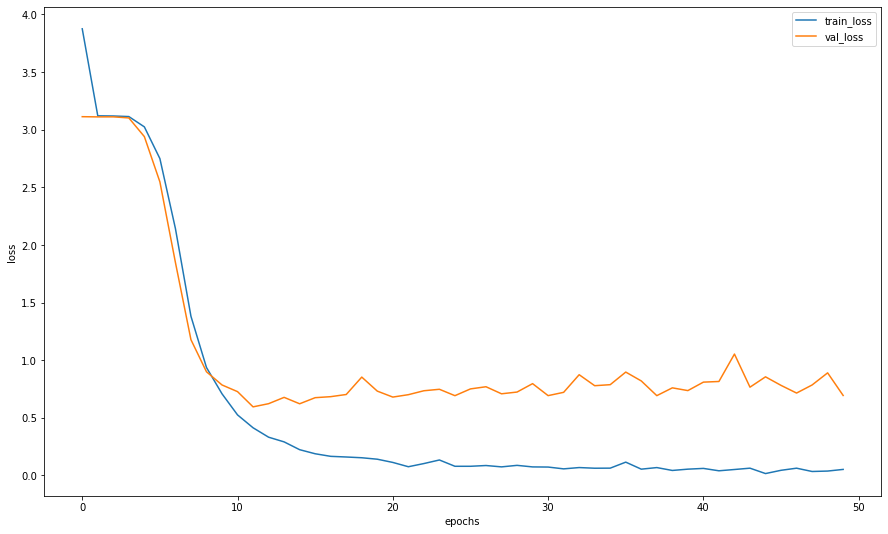

In [50]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Сделаем оценку f1 score на 1000 случайных картинках из валиационного датасета

In [57]:
from sklearn.metrics import f1_score 
def make_f1_score(model, n=1000):
    
    idxs = list(map(int, np.random.uniform(0,n, n)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]
    preds_class = list(y_pred)

    return f1_score(actual_labels, preds_class, average='micro')

In [55]:
make_f1_score(model_resnet)

KeyboardInterrupt: 

In [58]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

Делаем предсказания на тестовых данных

In [59]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

Делаем сабмит на kaggle

In [61]:


my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv("e:\\labels.csv", index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]



my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv("e:\\labels.csv", index=False)
my_submit.head()